# CLustering Auckland Central Suburbs using data from Foursquare and K-Means Algorithm

## Table of Contents
1. [Introduction](#intro)
2. [Methodology](#method)
3. [Analysis](#analysis)
4. [Result](#result)
5. [Discussion](#discussion)
6. [Conclusion](#conclusion)
7. [References](#reference)

# 1. Introduction <a name="intro"></a>
## 1.1 Description & Disscusion of the Background
The year of 2020, mankind is at war with an unprecedented Covid-19 pandemic, indeed, we would have a World version 2.0 when Covid-19 is over. In New Zealand, we have been in lockdown mode for four weeks since mid-night 25/03/2020 and as a result, many businesses have had to close their businesses and lay off thousands of employees. New Zealand government had unveiled a 12.1 $b stimulus package in response to Covid-19 to help businesses, hospitals, Kiwis and so on __[1]__. It is a belief that the economy will bounce back stronger once Covid-19 is over. So, whilst we are staying home and relying on government and frontline workers to fight Covid-19, we could use the available data to find out new business opportunities. 

Currently, I am living in Auckland which is the biggest city in New Zealand with 1.66 million people in 2017 __[2]__ and NZ Stats medium projection showed Auckland population would have an increase of 833,000 – from just under 1.5 million to over 2.3 million by 2043 __[3]__. With all these figures, we can see that Auckland is having many opportunities for and its residents and investors. To limit my research, I focus on Auckland Central suburbs which I found on Wikipedia. Furthermore, I will use venues data from Foursquare to cluster each suburb according to the venue density. 

## 1.2 Data Description
To cluster each suburb, the following data will be used:
* I use Beautiful Soup, a Python package to extract Auckland Central suburbs from Wikipedia. However, the list of Auckland Central suburbs does not contain GPS coordinates so I use Google to manually find and fill in the latitude and longitude for each suburb.


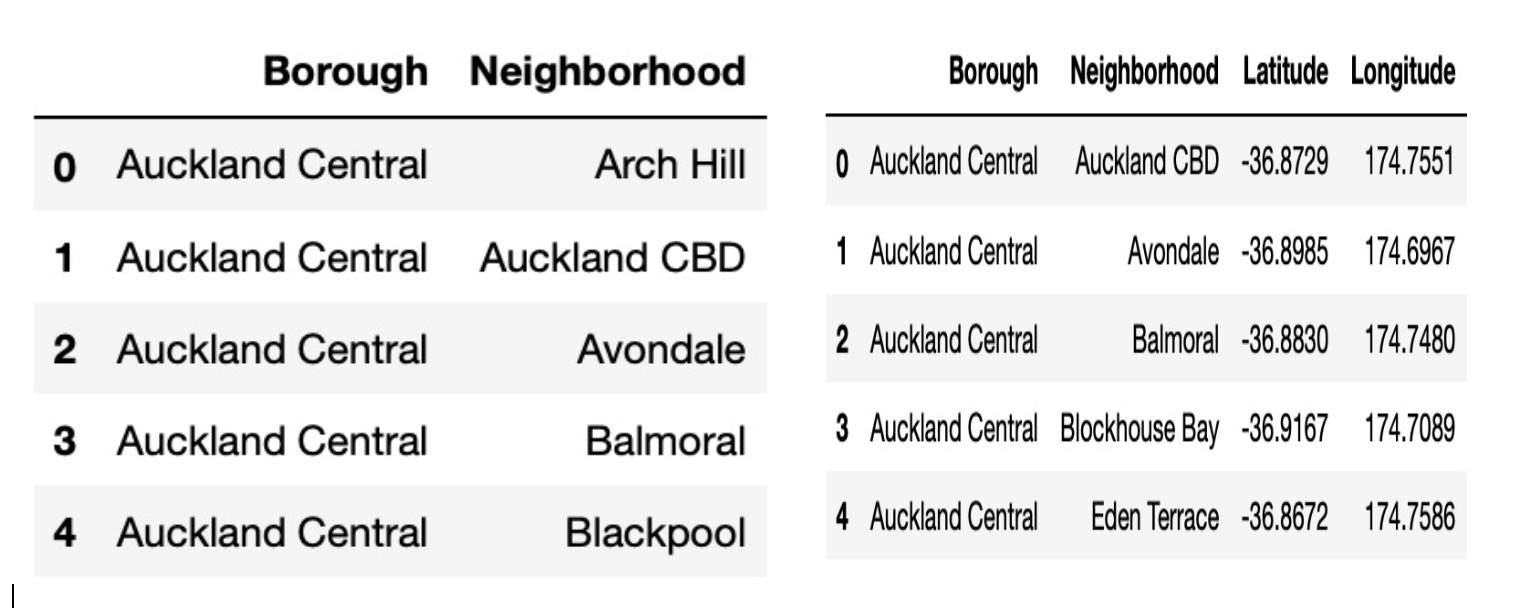


* Next, I use Folium to map all these suburbs and cross-check with Central Suburbs New Network Map from Auckland Transport to remove any suburbs do not belong to the Auckland Central area.

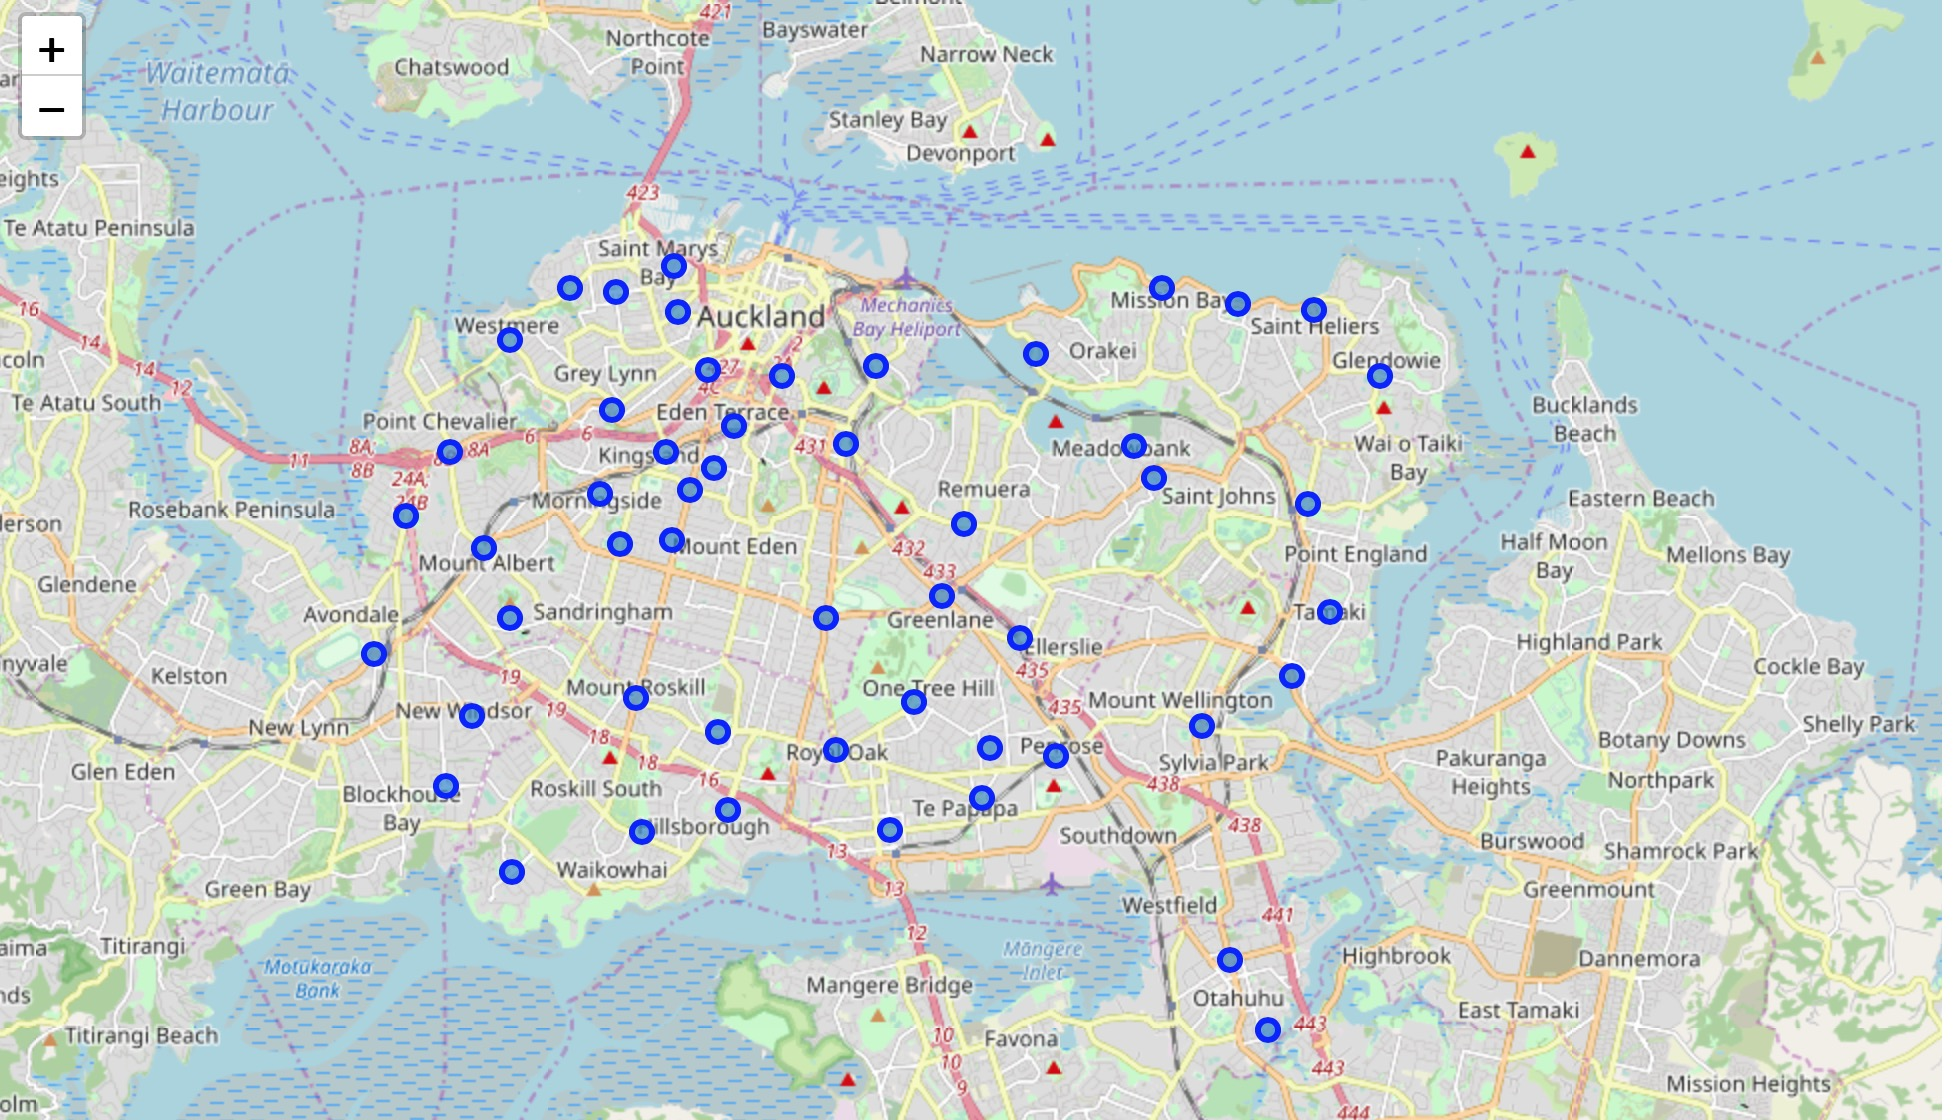

* Auckland AT map __[4]__.

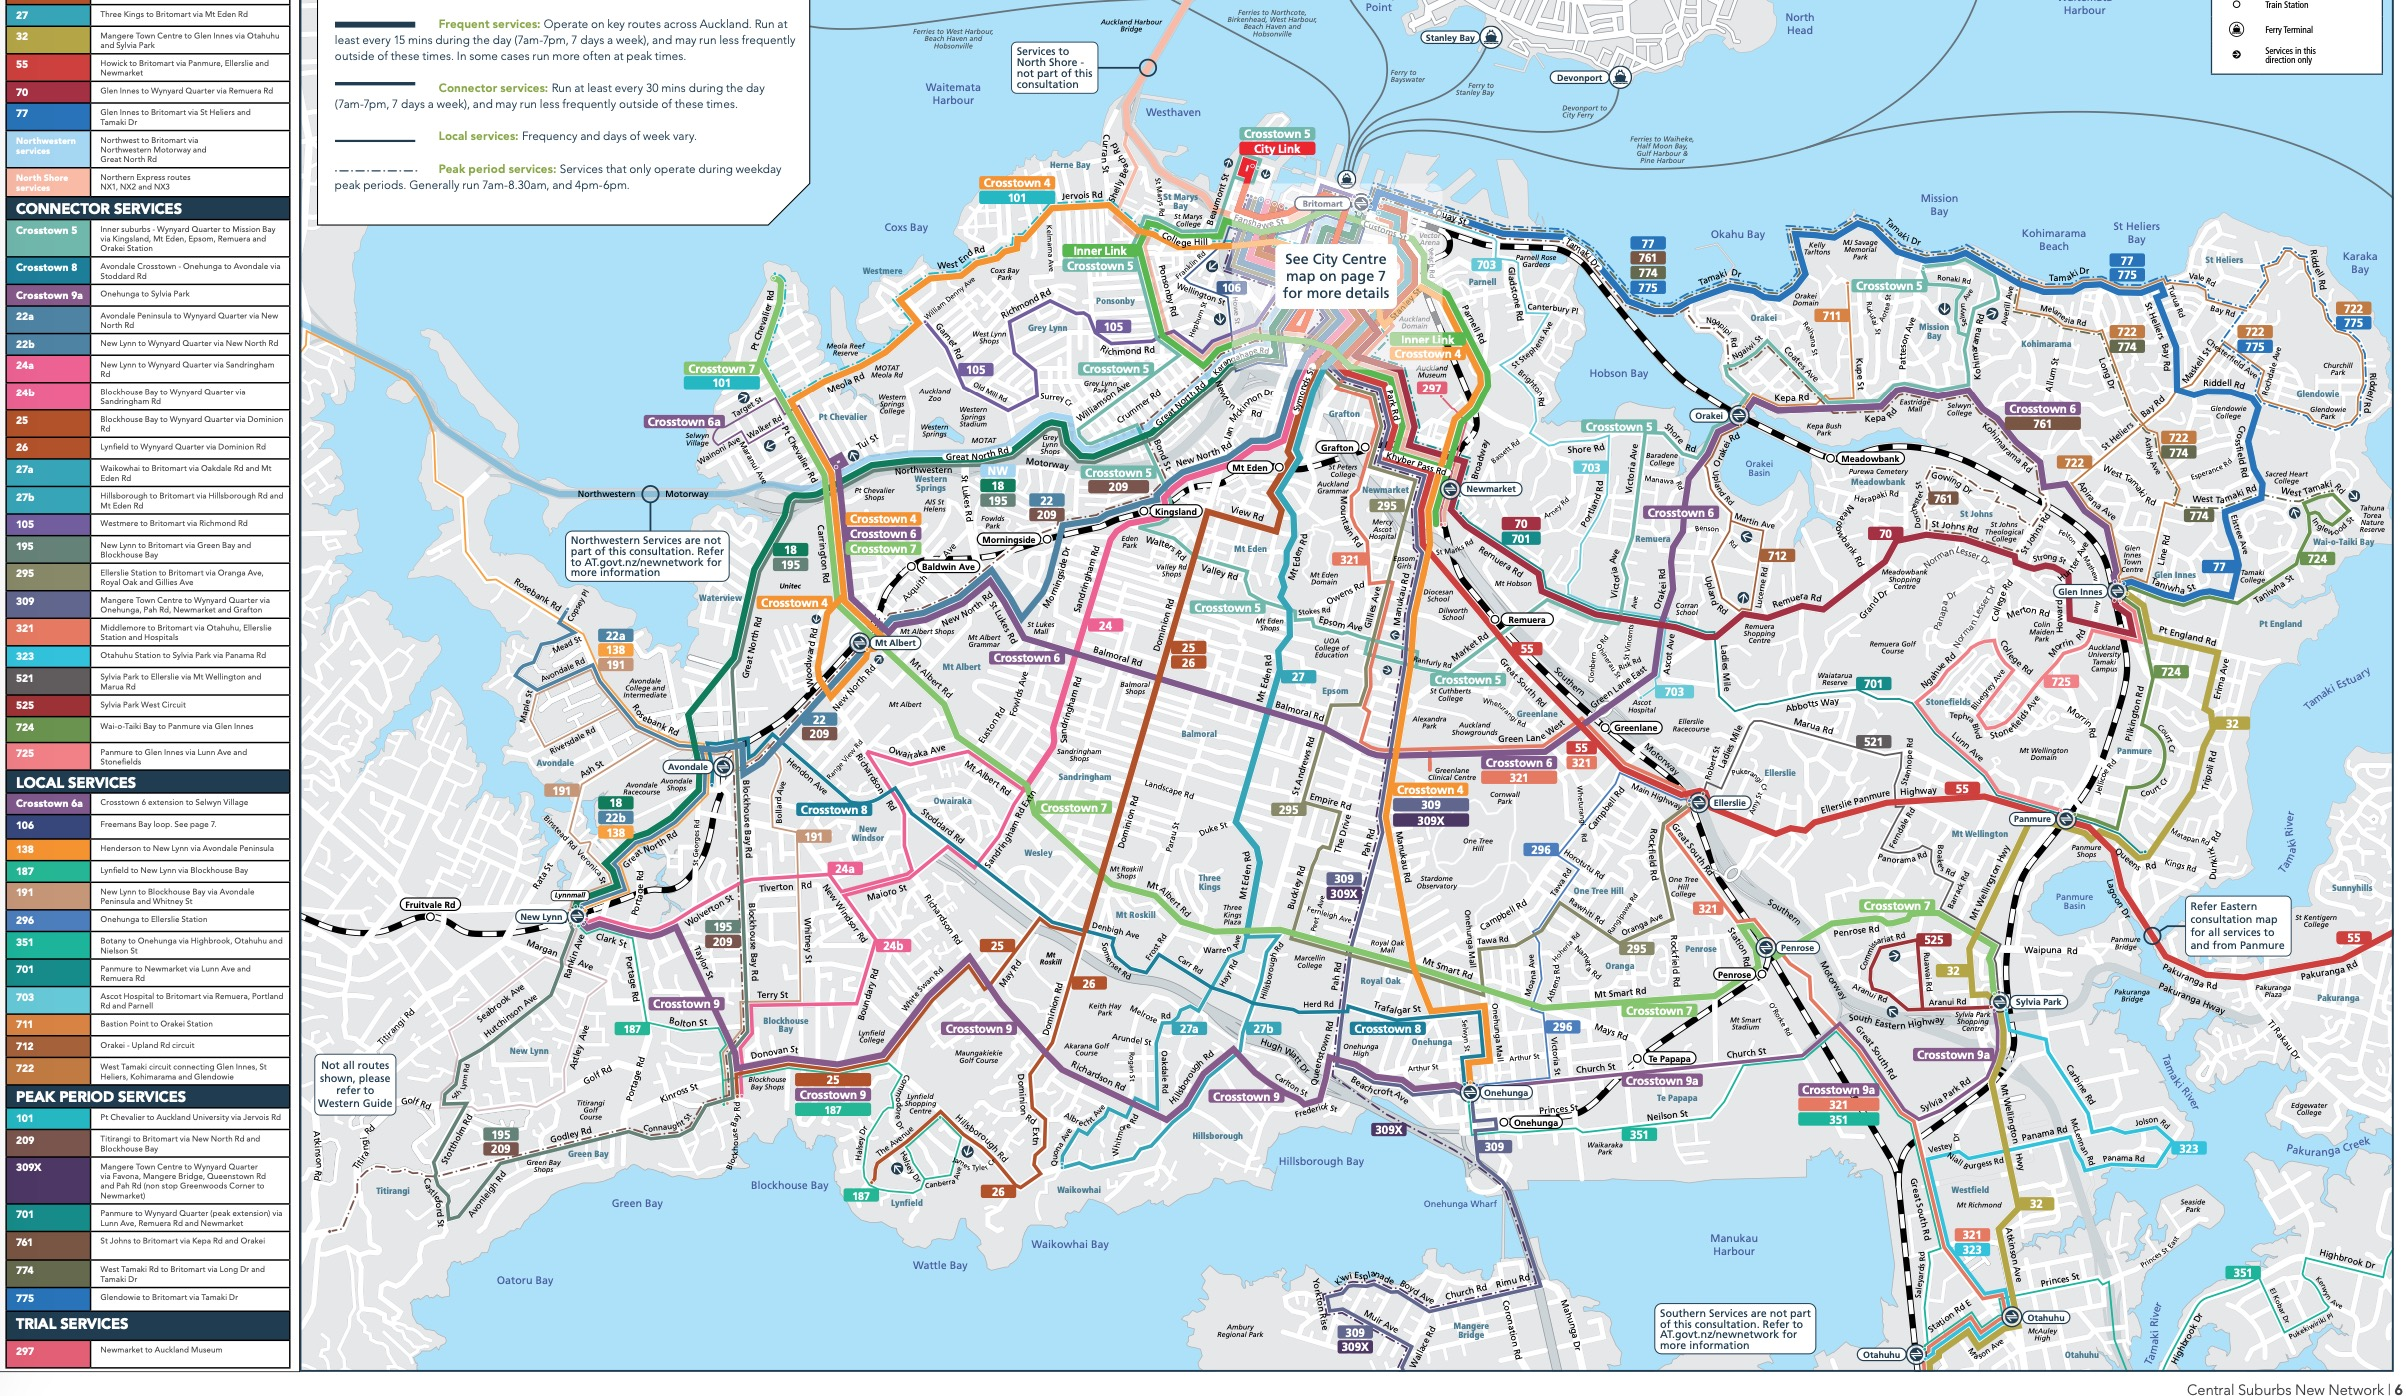
 
* After cross-check with Auckland AT map, the map created by Folium is correct. 

* I use  Foursquare API to retrieve the most common venues of the Auckland Central.

# 2. Methodology <a name="method"></a>
To conduct this analysis, the bellow tools and techniques will be utilised:
* GitHub will be used to store all data files.
* Jupyter Notebook will be used to writing report and coding.
* Foursquare API will be used to extract venues data for each Auckland suburb. I set the limit of 100 venues and the radius of 500 meters from each suburb. 
* Python and it's libraries including sklearn, folium and so on will be used. 
* K-Means, unsupervised machine learning technique will be used to cluster these suburbs. The optimal k number will be identified first in the section 3. Analysis before clustering. 
* After these suburbs have been clustered, they will be mapped again using folium. 


# 3. Analysis <a name="analysis"></a>

In [1]:
# !pip install geopy

In [2]:
from bs4 import BeautifulSoup
import requests
import csv
import numpy as np 

import pandas as pd 

# !pip install geopy # uncomment to install
from geopy.geocoders import Nominatim 
import requests 
from pandas.io.json import json_normalize


import matplotlib.cm as cm
import matplotlib.colors as colors


from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler


# !pip install folium # uncomment to install
import folium 

%matplotlib inline
print('Libraries imported.')

Libraries imported.


# Scraping Data from Wikipedia

In [3]:
source = requests.get('https://en.wikipedia.org/wiki/List_of_suburbs_of_Auckland').text
soup = BeautifulSoup(source, 'lxml')

csv_file = open('akl.csv', 'w')
csv_writer = csv.writer(csv_file)

csv_writer.writerow(['Borough', 'Neighborhood'])

akl_table = soup.find('div', {'class':'div-col columns column-width'} )
    
for tag in akl_table.find_all('a'):
    nei = tag.text
    bor = 'Auckland Central'
    csv_writer.writerow([bor, nei])

    
csv_file.close()


In [4]:
akl_df = pd.read_csv('akl.csv')
akl_df.head()

,Borough,Neighborhood
0,Auckland Central,Arch Hill
1,Auckland Central,Auckland CBD
2,Auckland Central,Avondale
3,Auckland Central,Balmoral
4,Auckland Central,Blackpool


In [5]:
akl_c_df = pd.read_csv('alk_c.csv')
akl_c_df.head()

,Borough,Neighborhood,Latitude,Longitude
0,Auckland Central,Auckland CBD,-36.8729,174.7551
1,Auckland Central,Avondale,-36.8985,174.6967
2,Auckland Central,Balmoral,-36.8830,174.7480
3,Auckland Central,Blockhouse Bay,-36.9167,174.7089
4,Auckland Central,Eden Terrace,-36.8672,174.7586


## Use geopy library to get the latitude and longitude values of Auckland

In [6]:
address = 'Auckland, New Zealand'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Auckland are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Auckland are -36.852095, 174.7631803.


## Create a map of Auckland with neighborhoods superimposed on top.

In [7]:
# create map of Toronto using latitude and longitude values
map_auckland = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(akl_c_df['Latitude'], akl_c_df['Longitude'], akl_c_df['Borough'], akl_c_df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_auckland)  
    
map_auckland

## Define Foursquare Credentials and Version

In [8]:
# Foursquare credential
CLIENT_ID = '4EC3BF3LSOIMQCCGR0VTWGLS3APSOZ1OWVK1QRSREYX5RNCC' # your Foursquare ID
CLIENT_SECRET = 'AJKDLHQEWLKIFOQGOFZEDHHW53Y2UZAHMKVUO5FT4FZFLQSP' # your Foursquare Secret
VERSION = '20180604' # Foursquare API version


## Get Lat and Long of Auckland CBD

In [9]:
neighborhood_latitude = akl_c_df.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = akl_c_df.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = akl_c_df.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Auckland CBD are -36.8729, 174.7551.


## Let's get the top 100 venues that are in Auckland within a radius of 500 meters.

In [10]:
LIMIT = 100
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
results = requests.get(url).json()
# results

In [11]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [12]:
# clean the json and structure it into a pandas dataframe.
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()


/Users/Mike/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  after removing the cwd from sys.path.


,name,categories,lat,lng
0,Tuihana Cafe. Foodstore.,Café,-36.872585,174.752230
1,Eden Noodles Cafe,Chinese Restaurant,-36.871956,174.752140
2,BurgerFuel,Burger Joint,-36.876184,174.751362
3,Mt Eden Swimming Pool,Gym Pool,-36.875666,174.756638
4,Vinyl Coffee Shop,Café,-36.875513,174.751243


In [13]:
# how many venues were returned by Foursquare
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

18 venues were returned by Foursquare.


# Explore Neighborhoods in Auckland

### A function to repeat the same process to all the neighborhoods in Auckland

In [14]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [15]:
# create a new dataframe called toronto_venues.
auckland_venues = getNearbyVenues(names=akl_c_df['Neighborhood'],
                                   latitudes=akl_c_df['Latitude'],
                                   longitudes=akl_c_df['Longitude']
                                  )

Auckland CBD
Avondale
Balmoral
Blockhouse Bay
Eden Terrace
Ellerslie
Epsom
Freemans Bay
Glendowie
Glen Innes
Grafton
Greenlane
Grey Lynn
Herne Bay
Hillsborough
Kingsland
Kohimarama
Lynfield
Meadowbank
Mission Bay
Morningside
Mount Albert
Mount Eden
Mount Roskill
Mount Wellington
Newmarket
Newton
New Windsor
Onehunga
One Tree Hill
Orakei
Otahuhu
Oranga
Owairaka
Panmure
Parnell
Penrose
Point Chevalier
Ponsonby
Remuera
Royal Oak
Saint Heliers
Saint Johns
Saint Marys Bay
Sandringham
Tamaki
Te Papapa
Three Kings
Waikowhai
Waterview
Westfield


#### Check the size of the resulting dataframe

In [16]:
print(auckland_venues.shape)
auckland_venues.head()

(641, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Auckland CBD,-36.8729,174.7551,Tuihana Cafe. Foodstore.,-36.872585,174.752230,Café
1,Auckland CBD,-36.8729,174.7551,Eden Noodles Cafe,-36.871956,174.752140,Chinese Restaurant
2,Auckland CBD,-36.8729,174.7551,BurgerFuel,-36.876184,174.751362,Burger Joint
3,Auckland CBD,-36.8729,174.7551,Mt Eden Swimming Pool,-36.875666,174.756638,Gym Pool
4,Auckland CBD,-36.8729,174.7551,Vinyl Coffee Shop,-36.875513,174.751243,Café


In [17]:
# check how many venues were returned for each neighborhood
auckland_venues.groupby('Neighborhood').count().head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Auckland CBD,18,18,18,18,18,18
Avondale,4,4,4,4,4,4
Balmoral,8,8,8,8,8,8
Blockhouse Bay,3,3,3,3,3,3
Eden Terrace,24,24,24,24,24,24


#### Find out how many unique categories can be curated from all the returned venues

In [18]:
print('There are {} uniques categories.'.format(len(auckland_venues['Venue Category'].unique())))

There are 148 uniques categories.


# Analyze Each Neighborhood

In [19]:
# one hot coding
auckland_onehot = pd.get_dummies(auckland_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
auckland_onehot['Neighborhood'] = auckland_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [auckland_onehot.columns[-1]] + list(auckland_onehot.columns[:-1])
auckland_onehott = auckland_onehot[fixed_columns]

auckland_onehot.head()

,African Restaurant,American Restaurant,Antique Shop,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bar,...,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [20]:
auckland_grouped = auckland_onehot.groupby('Neighborhood').mean().reset_index()
auckland_grouped.head()

,Neighborhood,African Restaurant,American Restaurant,Antique Shop,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,...,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop
0,Auckland CBD,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
1,Avondale,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
2,Balmoral,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
3,Blockhouse Bay,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
4,Eden Terrace,0.0,0.041667,0.0,0.0,0.083333,0.0,0.0,0.041667,0.0,...,0.0,0.0,0.0,0.041667,0.0,0.0,0.0,0.041667,0.0,0.0


#### Print each neighborhood along with the top 5 most common venues

In [21]:
num_top_venues = 5

for hood in auckland_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = auckland_grouped[auckland_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Auckland CBD----
                   venue  freq
0                   Café  0.22
1          Grocery Store  0.11
2                    Bar  0.11
3                 Hostel  0.06
4  Portuguese Restaurant  0.06


----Avondale----
                 venue  freq
0          Coffee Shop  0.25
1                 Café  0.25
2          Salad Place  0.25
3  Fried Chicken Joint  0.25
4   African Restaurant  0.00


----Balmoral----
                  venue  freq
0                  Café  0.25
1  Fast Food Restaurant  0.25
2            Restaurant  0.12
3                  Park  0.12
4          Gourmet Shop  0.12


----Blockhouse Bay----
                venue  freq
0        Tennis Court  0.33
1     Thai Restaurant  0.33
2                Park  0.33
3  African Restaurant  0.00
4     Organic Grocery  0.00


----Eden Terrace----
                 venue  freq
0     Asian Restaurant  0.08
1                 Café  0.08
2                  Pub  0.08
3  Japanese Restaurant  0.04
4          Coffee Shop  0.04


----Eller

                 venue  freq
0                 Café  0.14
1   Seafood Restaurant  0.10
2          Coffee Shop  0.10
3  Japanese Restaurant  0.05
4      Thai Restaurant  0.05


----Sandringham----
               venue  freq
0  Electronics Store  0.11
1    Thai Restaurant  0.11
2  Mobile Phone Shop  0.11
3   Sushi Restaurant  0.11
4   Department Store  0.11


----Tamaki----
                    venue  freq
0  Furniture / Home Store   1.0
1                   Motel   0.0
2           Movie Theater   0.0
3               Multiplex   0.0
4             Music Venue   0.0


----Te Papapa----
                venue  freq
0           Roof Deck  0.33
1   Fish & Chips Shop  0.33
2              Bakery  0.33
3  African Restaurant  0.00
4  Persian Restaurant  0.00


----Three Kings----
                   venue  freq
0     Chinese Restaurant  0.50
1            Supermarket  0.25
2                    Bar  0.25
3  Portuguese Restaurant  0.00
4             Playground  0.00


----Waikowhai----
               ve

#### Put that into a pandas dataframe

In [22]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### Create the new dataframe and display the top 10 venues for each neighborhood.

In [23]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = auckland_grouped['Neighborhood']

for ind in np.arange(auckland_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(auckland_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Auckland CBD,Café,Grocery Store,Bar,Hostel,Pizza Place,Portuguese Restaurant,Park,Food & Drink Shop,Chinese Restaurant,Bus Station
1,Avondale,Fried Chicken Joint,Café,Salad Place,Coffee Shop,Wine Shop,Flower Shop,French Restaurant,Food Truck,Food Court,Food & Drink Shop
2,Balmoral,Café,Fast Food Restaurant,Restaurant,Park,Gourmet Shop,Malay Restaurant,Wine Shop,Flower Shop,French Restaurant,Food Truck
3,Blockhouse Bay,Thai Restaurant,Park,Tennis Court,Wine Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Flower Shop
4,Eden Terrace,Café,Asian Restaurant,Pub,Pizza Place,Seafood Restaurant,French Restaurant,Fruit & Vegetable Store,Cocktail Bar,Coffee Shop,Brewery


## Find the optimal k number

In [49]:
# create test dataframe
akl_test = auckland_onehot.copy()
akl_test.drop(['Neighborhood'], axis = 1, inplace= True)

mms =MinMaxScaler()
mms.fit(akl_test)
df_transformed = mms.transform(akl_test)

Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_transformed)
    Sum_of_squared_distances.append(km.inertia_)
    

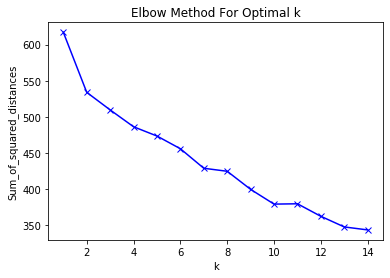

In [50]:
# Visualise

import matplotlib.pyplot as plt
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

So, as shown in the graph above, the optimal k is 7. 

# 4. Result <a name="result"></a>

## Cluster Neighborhoods

#### Run k-means to cluster the neighborhood into 7 clusters

In [26]:
# set number of clusters
kclusters = 7

auckland_grouped_clustering = auckland_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(auckland_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 3, 3, 4, 0, 3, 0, 3, 0, 1], dtype=int32)

#### Create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood

In [27]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

auckland_merged = akl_c_df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
auckland_merged = auckland_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

auckland_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Auckland Central,Auckland CBD,-36.8729,174.7551,3,Café,Grocery Store,Bar,Hostel,Pizza Place,Portuguese Restaurant,Park,Food & Drink Shop,Chinese Restaurant,Bus Station
1,Auckland Central,Avondale,-36.8985,174.6967,3,Fried Chicken Joint,Café,Salad Place,Coffee Shop,Wine Shop,Flower Shop,French Restaurant,Food Truck,Food Court,Food & Drink Shop
2,Auckland Central,Balmoral,-36.8830,174.7480,3,Café,Fast Food Restaurant,Restaurant,Park,Gourmet Shop,Malay Restaurant,Wine Shop,Flower Shop,French Restaurant,Food Truck
3,Auckland Central,Blockhouse Bay,-36.9167,174.7089,4,Thai Restaurant,Park,Tennis Court,Wine Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Flower Shop
4,Auckland Central,Eden Terrace,-36.8672,174.7586,0,Café,Asian Restaurant,Pub,Pizza Place,Seafood Restaurant,French Restaurant,Fruit & Vegetable Store,Cocktail Bar,Coffee Shop,Brewery


#### Visualize the resulting clusters

In [28]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(auckland_merged['Latitude'], auckland_merged['Longitude'], auckland_merged['Neighborhood'], auckland_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine Clusters

### Cluster 1

In [29]:
auckland_merged.loc[auckland_merged['Cluster Labels'] == 0, auckland_merged.columns[[1] + list(range(5, auckland_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Eden Terrace,Café,Asian Restaurant,Pub,Pizza Place,Seafood Restaurant,French Restaurant,Fruit & Vegetable Store,Cocktail Bar,Coffee Shop,Brewery
6,Epsom,Chinese Restaurant,Japanese Restaurant,Dim Sum Restaurant,Antique Shop,Mongolian Restaurant,Asian Restaurant,Fruit & Vegetable Store,Racetrack,Bakery,Indian Restaurant
9,Glen Innes,Fast Food Restaurant,Cantonese Restaurant,Pizza Place,Pet Store,Supermarket,Grocery Store,Filipino Restaurant,Big Box Store,Wine Shop,French Restaurant
14,Hillsborough,Bakery,Athletics & Sports,Park,Wine Shop,Flower Shop,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court
15,Kingsland,Chinese Restaurant,Café,Middle Eastern Restaurant,Thai Restaurant,Bar,Tapas Restaurant,Bus Station,Burger Joint,Skate Park,Mexican Restaurant
17,Lynfield,Pizza Place,Grocery Store,Shopping Mall,Sandwich Place,Burger Joint,Bar,Fast Food Restaurant,Falafel Restaurant,Filipino Restaurant,Fish & Chips Shop
23,Mount Roskill,Tea Room,Asian Restaurant,Park,Video Store,Grocery Store,Bakery,Kids Store,Wine Shop,French Restaurant,Food Truck
24,Mount Wellington,Burger Joint,Pizza Place,Athletics & Sports,Grocery Store,Flower Shop,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court
26,Newton,Thai Restaurant,Café,Gay Bar,Sporting Goods Shop,Market,Malay Restaurant,South Indian Restaurant,Hostel,Bar,Electronics Store
27,New Windsor,Indian Restaurant,Home Service,Bus Station,Convenience Store,Chinese Restaurant,Wine Shop,Food & Drink Shop,Fried Chicken Joint,French Restaurant,Food Truck


### Cluster 2

In [30]:
auckland_merged.loc[auckland_merged['Cluster Labels'] == 1, auckland_merged.columns[[1] + list(range(5, auckland_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Glendowie,Thai Restaurant,Wine Shop,Flower Shop,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Fishing Store


### Cluster 3

In [31]:
auckland_merged.loc[auckland_merged['Cluster Labels'] == 2, auckland_merged.columns[[1] + list(range(5, auckland_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
45,Tamaki,Furniture / Home Store,Dessert Shop,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Flower Shop,Fishing Store


### Cluster 4

In [32]:
auckland_merged.loc[auckland_merged['Cluster Labels'] == 3, auckland_merged.columns[[1] + list(range(5, auckland_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Auckland CBD,Café,Grocery Store,Bar,Hostel,Pizza Place,Portuguese Restaurant,Park,Food & Drink Shop,Chinese Restaurant,Bus Station
1,Avondale,Fried Chicken Joint,Café,Salad Place,Coffee Shop,Wine Shop,Flower Shop,French Restaurant,Food Truck,Food Court,Food & Drink Shop
2,Balmoral,Café,Fast Food Restaurant,Restaurant,Park,Gourmet Shop,Malay Restaurant,Wine Shop,Flower Shop,French Restaurant,Food Truck
5,Ellerslie,Café,Bar,Mexican Restaurant,Indian Restaurant,Thai Restaurant,Sandwich Place,Coffee Shop,Burger Joint,Grocery Store,Chinese Restaurant
7,Freemans Bay,Café,Bar,Restaurant,Italian Restaurant,Pub,Japanese Restaurant,Food Truck,Food & Drink Shop,Supermarket,Coffee Shop
10,Grafton,Café,Coffee Shop,Hotel,Convenience Store,Bakery,Hostel,Sushi Restaurant,Italian Restaurant,Gym,Restaurant
11,Greenlane,Café,Hotel,Fast Food Restaurant,Chinese Restaurant,Coffee Shop,Flower Shop,Supermarket,Train Station,French Restaurant,Food Truck
12,Grey Lynn,Café,Burger Joint,Vietnamese Restaurant,Pizza Place,Bistro,Flower Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court
13,Herne Bay,Café,Bus Station,River,Gym,Park,Chinese Restaurant,Beach,Flower Shop,French Restaurant,Food Truck
16,Kohimarama,Deli / Bodega,Café,Italian Restaurant,German Restaurant,Fish & Chips Shop,Beach,Wine Shop,Food & Drink Shop,Fried Chicken Joint,French Restaurant


### Cluster 5

In [33]:
auckland_merged.loc[auckland_merged['Cluster Labels'] == 4, auckland_merged.columns[[1] + list(range(5, auckland_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Blockhouse Bay,Thai Restaurant,Park,Tennis Court,Wine Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Flower Shop
33,Owairaka,Park,Dance Studio,Athletics & Sports,Fishing Store,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Flower Shop


### Cluster 6

In [34]:
auckland_merged.loc[auckland_merged['Cluster Labels'] == 5, auckland_merged.columns[[1] + list(range(5, auckland_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
47,Three Kings,Chinese Restaurant,Bar,Supermarket,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop


### Cluster 7

In [35]:
auckland_merged.loc[auckland_merged['Cluster Labels'] == 6, auckland_merged.columns[[1] + list(range(5, auckland_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Meadowbank,Indian Restaurant,Wine Shop,Fishing Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Flower Shop


# 5. Discussion <a name="discussion"></a>
The analysis result shows that each suburb has its unique character even though they have been clustered together. If the investors are looking for open new businesses, more data will be needed to provide a better view of each Auckland suburb. The population density, type (industrial zone, offices or universities zone will be counted), income, spending data should be included. Therefore, future study is needed as this analysis is just the first step to identifies the best business opportunities. 

As the author of this analysis, I will have to learn and practice more on machine learning knowledge and teachnique as the knowledge I gained from this IBM certificate programme is just the basic of Data Science and Machine Learning world.   


# 6. Conclusion <a name="conslusion"></a>

The purpose of this analysis is to identify business opportunities for post Covid-19. As the result shows that Auckland Central is very diverse with multiple venue categories. These 51 suburbs have been clustered into 7 clusters and top ten venues of each suburb have also identified. However, it is not a solid result that the investors can rely on to make the investment decision. The future study will be required to identify the best business opportunities for investors. 

# 7. References <a name="reference"></a>

1. <a href="https://www.beehive.govt.nz/release/121-billion-support-new-zealanders-and-business">New Zealand Government</a>
2. <a href="https://www.aucklandcouncil.govt.nz/plans-projects-policies-reports-bylaws/our-plans-strategies/auckland-plan/about-the-auckland-plan/Pages/aucklands-population.aspx">Auckland Council</a>
3. <a href="http://archive.stats.govt.nz/browse_for_stats/population/estimates_and_projections/projections-overview/subnat-pop-proj.aspx">NZ Stats</a>
4. <a href="https://at.govt.nz/media/1866062/central-suburbs-consultation-map.pdf">Auckland Transport</a>
